#### [PyTorch를 활용한 머신러닝, 딥러닝 철저 입문]
## [Chapter 6-3] 예제: 손글씨 이미지 분류

---

## \#1. Import Modules

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import load_digits
from sklearn import datasets, model_selection

import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline

---

## \#2. Load Data

### 2-1. Get MNIST Data

#### Jeina's Comment:
- 책에서 활용한 `datasets.fetch_mldata` 메서드는 sklearn 0.20 버전에서 더이상 쓰이지 않을거라는 warning 발생
- 실제로 Error가 발생하면서 loading이 제대로 되지 않았다.
- 대신 새로 업데이트 된 `datasets.fetch_openml` 메서드로 내려받았다.

In [2]:
mnist = datasets.fetch_openml('mnist_784', data_home='./data')
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

#### mnist data 의 X (feature) 를 255로 정규화 해서 변수에 저장

In [3]:
mnist_data = mnist.data / 255
mnist_data.shape

(70000, 784)

#### mnist data의 y (label)을 변수에 저장
- mnist data가 업데이트 되면서, label의 target value들이 모두 `string` type의 데이터가 되었으므로 `int`로 형변환을 해준다.

In [4]:
mnist_label = mnist.target
mnist_label = mnist_label.astype(int)
print(mnist_label.shape)
mnist_label

(70000,)


array([5, 0, 4, ..., 4, 5, 6])

---

## \#3. DataFrame

### 3-1. Create DataFrame in `df`

In [5]:
df = pd.DataFrame(mnist_data)
print(df.shape)
df.tail()

(70000, 784)


,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


총 70000개의 데이터이고, 각 데이터는 `784(=28*28)` 개의 feature로 이루어져있음을 알 수 있다.

---

## \#4. Show digit Image

digit 이미지의 샘플을 한 번 확인해보자.

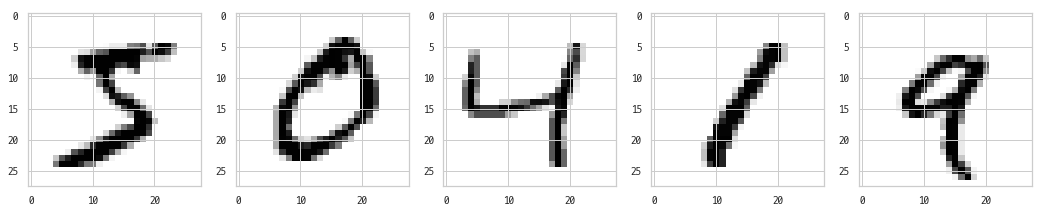

In [6]:
plt.figure(figsize=(18, 10))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(mnist_data[i].reshape(28, 28), cmap=cm.gray_r)
plt.show()

`0 ~ 255`사이의 값 (여기서는 정규화됨)을 가지는 grey scale의 이미지임을 확인할 수 있다.

---

## \#5. Training / Test Data

### 5-1. Get Train / Test data by `train_test_split`

train data는 70000개의 데이터 중 5000개, test data는 500개를 추출하기로 한다.

In [7]:
train_size = 5000
test_size = 500

train_X, test_X, train_y, test_y = model_selection.train_test_split(mnist_data, mnist_label, \
                                                                    train_size = train_size, test_size=test_size)

print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(5000, 784) (5000,)
(500, 784) (500,)


---

## \#6. Make Tensor

### 6-1. Transform Data Type

#### 완성된 train, test 데이터를 PyTorch의 `tensor 데이터`로 변환한다.

In [8]:
# train data
train_X = torch.from_numpy(train_X).float()
train_y = torch.from_numpy(train_y).long()

# test data
test_X = torch.from_numpy(test_X).float()
test_y = torch.from_numpy(test_y).long()

train_X.shape, train_y.shape

(torch.Size([5000, 784]), torch.Size([5000]))

#### train의 X와 y데이터를 `tensorDataset` 으로 합친다.

In [9]:
train = TensorDataset(train_X, train_y)
train[0][0][:5], train[0][1]

(tensor([0., 0., 0., 0., 0.]), tensor(2))

train의 각 element들은 feature와 label의 쌍으로 이루어져있음을 확인

### 6-2. Mini Batch

#### train 데이터를 미니배치로 학습시킬 수 있도록 100개 단위로 분할한다.

In [10]:
train_loader = DataLoader(train, batch_size=100, shuffle=True)

---

## \#7. Neural Network Composition

### 7-1. Neural Network class

In [11]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        # 입력층
        self.func1 = nn.Linear(784, 256)
        
        # 중간층(4층))
        self.func2 = nn.Linear(256, 256)
        self.func3 = nn.Linear(256, 256)
        self.func4 = nn.Linear(256, 256)
        self.func5 = nn.Linear(256, 256)
        
        # 출력층
        self.func6 = nn.Linear(256, 10)
        
        
    def forward(self, x):
        # 입력층 ~ 중간층(4층) : 활성화함수는 relu 함수 사용
        x = F.relu(self.func1(x))
        x = F.relu(self.func2(x))
        x = F.relu(self.func3(x))
        x = F.relu(self.func4(x))
        x = F.relu(self.func5(x))
        
        # dropout 구현
        x = F.dropout(x, training=self.training, p=0.5)
        
        # 출력층
        x = self.func6(x)
        
        # 출력층 활성화함수 : log_softmax
        y = F.log_softmax(x, dim=1)
        
        return y

### 7-2. NN Instance 생성

In [12]:
model = Net()
model

Net(
  (func1): Linear(in_features=784, out_features=256, bias=True)
  (func2): Linear(in_features=256, out_features=256, bias=True)
  (func3): Linear(in_features=256, out_features=256, bias=True)
  (func4): Linear(in_features=256, out_features=256, bias=True)
  (func5): Linear(in_features=256, out_features=256, bias=True)
  (func6): Linear(in_features=256, out_features=10, bias=True)
)

입력층과 중간층 4층, 그리고 출력층까지 확인

---

## \#8. Model Training

### 8-1. Loss Function

In [13]:
criterion = nn.CrossEntropyLoss()

### 8-2. Optimizer

In [14]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

### 8-3. Training

In [15]:
%%time
print("{} \t {}".format("epoch", "total loss"))
print("----- \t ----------------------")

for epoch in range(1000):
    total_loss = 0
    
    for train_X, train_y in train_loader:
        
        # 계산 그래프 구성
        train_X, train_y = Variable(train_X), Variable(train_y)
        
        # gradient 초기화
        optimizer.zero_grad()
        
        # forward 계산
        output = model.forward(train_X)
        
        # loss 계산
        loss = criterion(output, train_y)
        
        # 오차 역전파
        loss.backward()
        
        # gradient update
        optimizer.step()
        
        # 누적 오차 계산
        total_loss += loss.data
        
    # 50번째 epoch마다 loss 출력    
    if (epoch+1) % 100 == 0:
        print("{} \t {}".format(epoch+1, total_loss))

epoch 	 total loss
----- 	 ----------------------
100 	 34.955047607421875
200 	 4.097681999206543
300 	 0.3379775285720825
400 	 0.14065010845661163
500 	 0.060440998524427414
600 	 0.0877748653292656
700 	 0.04214557260274887
800 	 0.04590927064418793
900 	 0.035796478390693665
1000 	 0.019102295860648155
CPU times: user 6min 10s, sys: 27.1 s, total: 6min 37s
Wall time: 3min 35s


단 5층만으로도 잘 수렴하는 것을 알 수 있다!! 엄청나군

내 컴퓨터로는 약 3분 35초가 걸렸다..

---

## \#9. Accuracy

### 9-1. test data 로 accuracy 계산

In [16]:
# 계산 그래프 구성
test_X, test_y = Variable(test_X), Variable(test_y)

# 결과를 0 또는 1이 되도록 변환
result = torch.max(model(test_X).data, 1)[1]

# test_y 와 결과가 같은 예측값의 개수 (맞춘 개수) 계산
accuracy = sum(test_y.data.numpy() == result.numpy()) / len(test_y.data.numpy())

accuracy

0.926

약 92.6%의 엄청난 정확도를 자랑한다 으악